In [1]:
import matplotlib.pyplot as plt
import numpy as np
import SSLimPy.interface.config as config


before {'h': 0.67, 'Omegam': 0.32, 'Omegab': 0.04, 'As': 2.1e-09, 'mnu': 0.06}
after {'h': 0.67, 'Omegam': 0.32, 'Omegab': 0.04, 'As': 2.1e-09, 'mnu': 0.06, 'ns': 0.96, 'Neff': 3.043}
{'k_per_decade_for_bao': 50, 'k_per_decade_for_pk': 50, 'P_k_max_1/Mpc': 50, 'output': 'mPk,mTk', 'non linear': 'halofit', 'z_max_pk': 4.0, 'N_ncdm': 1, 'T_cmb': 2.7255, 'nonlinear_min_k_max': 80.0, 'halofit_tol_sigma': 1e-08, 'k_pivot': 0.05, 'YHe': 0.2454006, 'h': 0.67, 'Omegam': 0.32, 'Omegab': 0.04, 'As': 2.1e-09, 'mnu': 0.06, 'ns': 0.96, 'Neff': 3.043}
before {'h': 0.67, 'Omegam': 0.32, 'Omegab': 0.04, 'As': 2.1e-09, 'mnu': 0.06}
after {'h': 0.67, 'Omegam': 0.32, 'Omegab': 0.04, 'As': 2.1e-09, 'mnu': 0.06, 'ns': 0.96, 'Neff': 3.043}


Text(0, 0.5, '% deviation camb class')

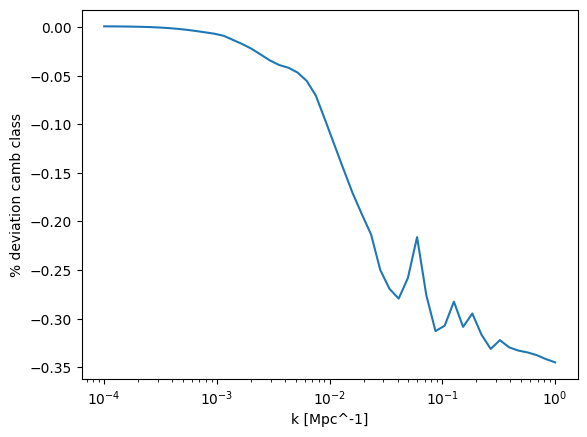

In [8]:
k= np.geomspace(1e-4,1)

cosmodict={"h":0.67,"Omegam":0.32,"Omegab":0.04,"As":2.1e-9, "mnu":0.06}
codes = ["class","camb"]
pk = []
for code in codes:
    settings = {"code":code}
    cfg = config.init(cosmopars=cosmodict, settings_dict=settings)
    pk.append(config.fiducialcosmo.Pmm(0,k))
pk = np.array(pk)

plt.plot(k,(pk[0,:]/pk[1,:]-1)*100)
plt.xscale("log")
plt.xlabel("k [Mpc^-1]")
plt.ylabel(r"% deviation camb class")